In [75]:
import nocap.utility as utility
import mira
import pyciemss
import networkx as nx
import matplotlib.pyplot as plt
import tellurium as te
from mira.sources.sbml import template_model_from_sbml_file
import pyciemss.visuals.plots as plots
from mira.modeling.ode import OdeModel
from mira.modeling.viz import GraphicalModel
from mira.modeling import Model


## Toy ABC GRN: 

A --> B (activation)

A --> C (repression)

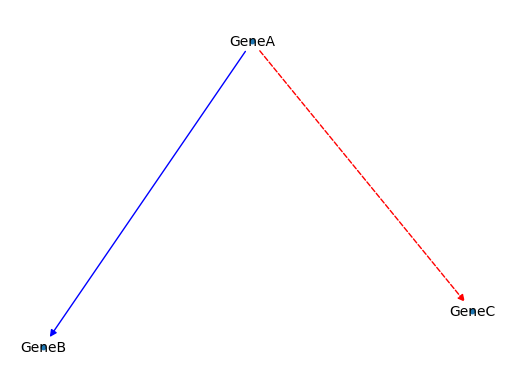

In [69]:
# create graph in networkx
ABC_graph= nx.DiGraph()
ABC_graph.add_node('GeneA', value=1.0)
ABC_graph.add_node('GeneB', value=0.0)
ABC_graph.add_node('GeneC', value=1.0)
ABC_graph.add_edge('GeneA', 'GeneB', interaction_type='activation')
ABC_graph.add_edge('GeneA', 'GeneC', interaction_type='repression')
G = ABC_graph

# plot the network
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw_networkx_nodes(G, pos, node_size=10)
activation_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'activation']
repression_edges = [(u, v) for u, v, d in G.edges(data=True) if d['interaction_type'] == 'repression']
nx.draw_networkx_edges(G, pos, edgelist=activation_edges, edge_color='blue', arrows=True)
nx.draw_networkx_edges(G, pos, edgelist=repression_edges, edge_color='red', arrows=True, style='dashed')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()

In [70]:
filename = "test_dag.xml"
utility.create_sbml_model_from_nx(G,filename)

Generated Antimony Model:
model grn_model()
  compartment default_compartment = 1;
  species GeneA in default_compartment;
  GeneA = 1;
  species GeneB in default_compartment;
  GeneB = 1;
  species GeneC in default_compartment;
  GeneC = 1;
  J_GeneA_to_GeneB: GeneA => GeneB; beta_GeneA_to_GeneB * GeneA^n_GeneA_to_GeneB / (K_GeneA_to_GeneB^n_GeneA_to_GeneB + GeneA^n_GeneA_to_GeneB);
  beta_GeneA_to_GeneB = 1.0; // units: mole_per_second
  K_GeneA_to_GeneB = 1.0; // units: mole
  n_GeneA_to_GeneB = 1.0; // units: dimensionless
  J_GeneA_to_GeneC: GeneA => GeneC; beta_GeneA_to_GeneC / (1 + (GeneA^n_GeneA_to_GeneC / K_GeneA_to_GeneC^n_GeneA_to_GeneC));
  beta_GeneA_to_GeneC = 1.0; // units: mole_per_second
  K_GeneA_to_GeneC = 1.0; // units: mole
  n_GeneA_to_GeneC = 1.0; // units: dimensionless
end
SBML model written to test_dag.xml


In [73]:
mira_model = template_model_from_sbml_file(filename)
display(mira_model.parameters)
display(mira_model.initials)


{'beta_GeneA_to_GeneB': Parameter(name='beta_GeneA_to_GeneB', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'n_GeneA_to_GeneB': Parameter(name='n_GeneA_to_GeneB', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'K_GeneA_to_GeneB': Parameter(name='K_GeneA_to_GeneB', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'beta_GeneA_to_GeneC': Parameter(name='beta_GeneA_to_GeneC', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'n_GeneA_to_GeneC': Parameter(name='n_GeneA_to_GeneC', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'K_GeneA_to_GeneC': Parameter(name='K_GeneA_to_GeneC', display_name=None, description='', identifiers={}, context={}, units=None, value=1.0, distribution=None),
 'default_compar

{'GeneA': Initial(concept=Concept(name='GeneA', display_name='GeneA', description=None, identifiers={}, context={}, units=None), expression=1.0),
 'GeneB': Initial(concept=Concept(name='GeneB', display_name='GeneB', description=None, identifiers={}, context={}, units=None), expression=1.0),
 'GeneC': Initial(concept=Concept(name='GeneC', display_name='GeneC', description=None, identifiers={}, context={}, units=None), expression=1.0)}

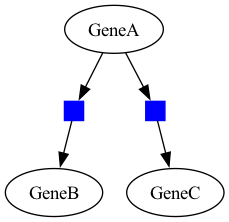

In [74]:
GraphicalModel.for_jupyter(mira_model)

In [77]:
om = OdeModel(Model(mira_model), initialized=True)
om.get_interpretable_kinetics()

Matrix([
[-GeneA**n_GeneA_to_GeneB*beta_GeneA_to_GeneB/(GeneA**n_GeneA_to_GeneB + K_GeneA_to_GeneB**n_GeneA_to_GeneB) - beta_GeneA_to_GeneC/(GeneA**n_GeneA_to_GeneC/K_GeneA_to_GeneC**n_GeneA_to_GeneC + 1)],
[                                                                                        GeneA**n_GeneA_to_GeneB*beta_GeneA_to_GeneB/(GeneA**n_GeneA_to_GeneB + K_GeneA_to_GeneB**n_GeneA_to_GeneB)],
[                                                                                                              beta_GeneA_to_GeneC/(GeneA**n_GeneA_to_GeneC/K_GeneA_to_GeneC**n_GeneA_to_GeneC + 1)]])

In [78]:
from mira.modeling.amr.petrinet import AMRPetriNetModel
from mira.modeling import Model
from pathlib import Path

petrinet_model_filename = 'test_petrinet.json'
file_root = Path(petrinet_model_filename).stem
petrinet_model = AMRPetriNetModel(Model(mira_model))
petrinet_model.to_json_file(
                petrinet_model_filename,
                name=file_root,
                description=file_root,
                indent=2,
            )

In [83]:
start_time = 0.0
end_time = 2
logging_step_size = 0.1
num_samples = 3

petrinet_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, start_time=start_time)
display(petrinet_results['data'].head())

,timepoint_id,sample_id,timepoint_unknown,GeneA_state,GeneB_state,GeneC_state
0,0,0,0.0,1.0,1.000000,1.000000
1,1,0,0.1,0.9,1.048707,1.051293
2,2,0,0.2,0.8,1.094640,1.105361
3,3,0,0.3,0.7,1.137481,1.162519
4,4,0,0.4,0.6,1.176856,1.223144


In [84]:
petrinet_results

{'data':     timepoint_id  sample_id timepoint_unknown  GeneA_state  GeneB_state  \
 0              0          0               0.0     1.000000     1.000000   
 1              1          0               0.1     0.900000     1.048707   
 2              2          0               0.2     0.800000     1.094640   
 3              3          0               0.3     0.700000     1.137481   
 4              4          0               0.4     0.600000     1.176856   
 ..           ...        ...               ...          ...          ...   
 58            16          2               1.6    -0.600000     0.990561   
 59            17          2               1.7    -0.700000     0.802881   
 60            18          2               1.8    -0.800000     0.497414   
 61            19          2               1.9    -0.900000    -0.095733   
 62            20          2               2.0    -0.999998   -11.416296   
 
     GeneC_state  
 0      1.000000  
 1      1.051293  
 2      1.105361  
 3

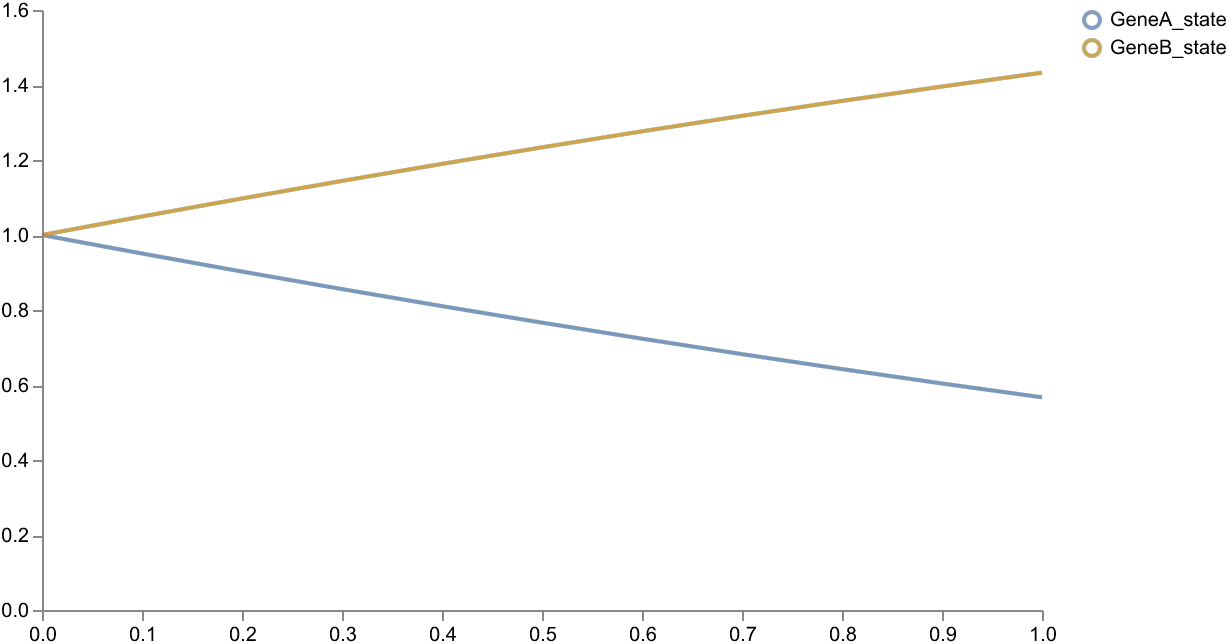

In [56]:
# Plot results for all states
schema = plots.trajectories(petrinet_results["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [57]:
## for priors use uniform(0,1)

from mira.metamodel import Distribution


dist = Distribution(
                    type= "Uniform1",
                    parameters= {"minimum": 0.5,"maximum": 1.5 }     
                     )

for name,parameter in mira_model.parameters.items():
    if name != "default_compartment":
        parameter.distribution = dist

petrinet_model_filename = 'test_petrinet_w_priors.json'
file_root = Path(petrinet_model_filename).stem
petrinet_model = AMRPetriNetModel(Model(mira_model))
petrinet_model.to_json_file(
                petrinet_model_filename,
                name=file_root,
                description=file_root,
                indent=2,
            )

In [58]:
rr_model = te.loadSBMLModel(filename)
rr_results = rr_model.simulate(0,1)

In [59]:
import pandas as pd    

data_filepath = "test_data.csv"
formatted_df = pd.DataFrame(rr_results, columns=rr_results.colnames)
formatted_df = formatted_df.set_index('time')
formatted_df.index.names = ['Timestamp']  # must be 'Timestamp' for pyciemss

formatted_df.columns = formatted_df.columns.str.replace('[', '', regex=False).str.replace(']', '', regex=False)
formatted_df.to_csv(data_filepath)

formatted_df.head()


,GeneA,GeneB
Timestamp,,
0.00,1.000000,1.000000
0.02,0.990026,1.009974
0.04,0.980101,1.019899
0.06,0.970227,1.029773
0.08,0.960404,1.039596


In [60]:
num_iterations = 100
data_to_use = formatted_df
data_path = data_filepath
model_path_or_json = petrinet_model_filename

data_mapping = {k:k for k in data_to_use.columns}  # remove '[]' for concentration added by Tellurium
print(data_mapping)
calibration_results = pyciemss.calibrate(model_path_or_json, data_path, data_mapping=data_mapping, num_iterations=num_iterations, verbose=True)

{'GeneA': 'GeneA', 'GeneB': 'GeneB'}
Data printout: This dataset contains 50 rows of data. The first column, Timestamp, begins at 0.0 and ends at 1.0. The subsequent columns are named: GeneA, GeneB
iteration 0: loss = -115.72865915298462


/Users/geor228/miniconda3/envs/NOCAP_env/lib/python3.11/site-packages/pyciemss/integration_utils/observation.py:49: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



iteration 25: loss = -137.26311492919922
iteration 50: loss = -140.92321956157684
iteration 75: loss = -140.37815630435944


In [61]:
parameter_estimates = calibration_results["inferred_parameters"]
parameter_estimates()

{'persistent_K_GeneA_to_GeneB': tensor(1.2119, grad_fn=<ExpandBackward0>),
 'persistent_beta_GeneA_to_GeneB': tensor(1.0017, grad_fn=<ExpandBackward0>),
 'persistent_n_GeneA_to_GeneB': tensor(0.7586, grad_fn=<ExpandBackward0>)}

In [62]:
# set simulation and sampling parameters
start_time = 0.0
end_time = 1
logging_step_size = 0.1	#1.0
num_samples = 10

calibrated_sample_results = pyciemss.sample(petrinet_model_filename, end_time, logging_step_size, num_samples, 
                start_time=start_time, inferred_parameters=parameter_estimates)
display(calibrated_sample_results["data"].head())

,timepoint_id,sample_id,timepoint_unknown,persistent_K_GeneA_to_GeneB_param,persistent_beta_GeneA_to_GeneB_param,persistent_n_GeneA_to_GeneB_param,GeneA_state,GeneB_state
0,0,0,0.0,1.328039,1.189907,1.059398,1.000000,1.000000
1,1,0,0.1,1.328039,1.189907,1.059398,0.950162,1.049840
2,2,0,0.2,1.328039,1.189907,1.059398,0.901900,1.098100
3,3,0,0.3,1.328039,1.189907,1.059398,0.855229,1.144772
4,4,0,0.4,1.328039,1.189907,1.059398,0.810159,1.189841


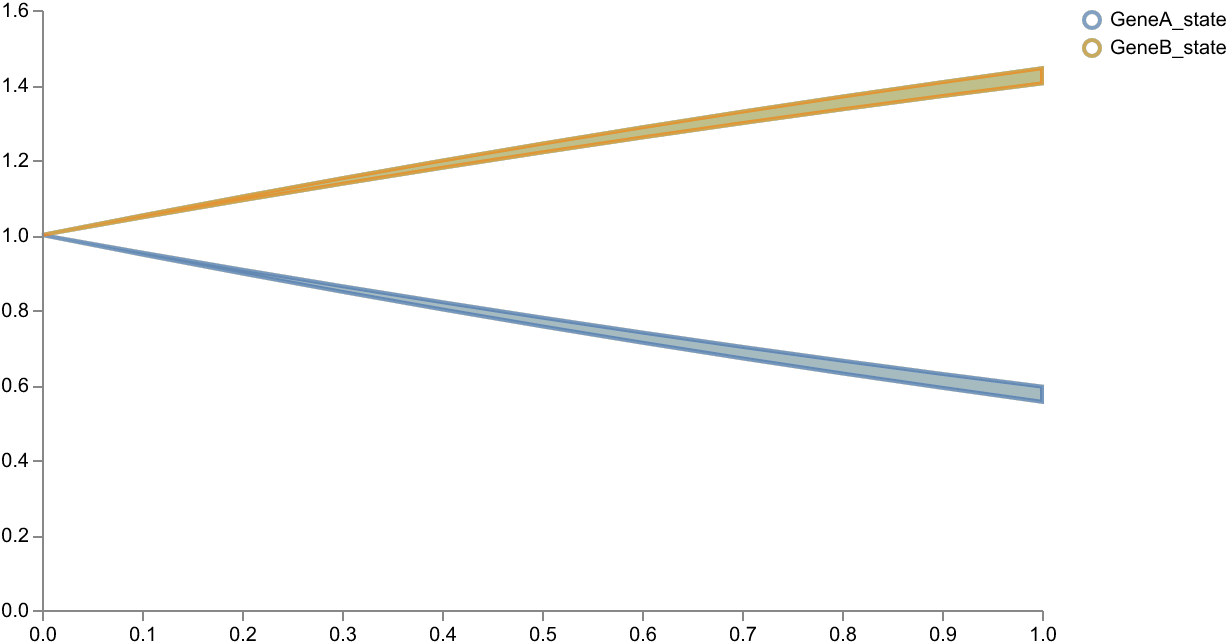

In [64]:
# Plot results for all states
schema = plots.trajectories(calibrated_sample_results["data"], keep=".*_state")
plots.save_schema(schema, "_schema.json")
plots.ipy_display(schema, dpi=150)

In [65]:
# parameter intervention - before calibration

In [ ]:
# parameter intervention - after calibration (counterfactual)

In [ ]:
# compare intevened vs unintervened 